In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

import csv

%matplotlib inline

In [2]:
from osgeo import gdal
from osgeo import osr

In [3]:
# Download arrays
#!wget https://github.com/nansencenter/sea_ice_drift_test_files/raw/master/S1B_EW_GRDM_1SDH_20200123T120618.npy
#!wget https://github.com/nansencenter/sea_ice_drift_test_files/raw/master/S1B_EW_GRDM_1SDH_20200125T114955.npy
f1 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/subset_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV_Cnv.tif")
f2 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/subset_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV_Cnv.tif")
f3 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/Hourly_aligned_mean_ens_20221120T09_subset_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV_Cnv.tif")

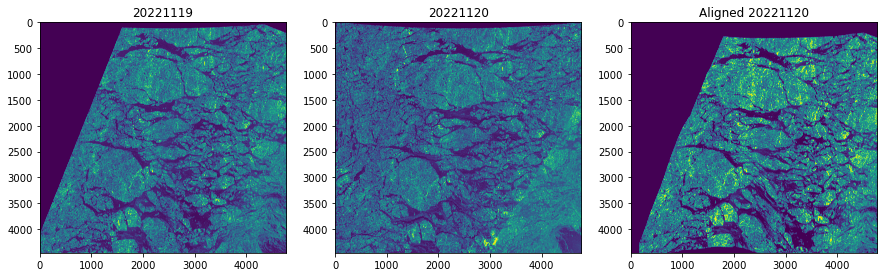

In [4]:
# load example ar2rays
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()
a3 = f3.ReadAsArray()

fig, ax = plt.subplots(1,3, figsize=(15,10))

im0 = ax[0].imshow(a1)
im1 = ax[1].imshow(a2)
im1 = ax[2].imshow(a3)

ax[0].set_title("20221119")
ax[1].set_title("20221120")
ax[2].set_title("Aligned 20221120")

plt.show()



In [5]:
# Create two Nansat objects with original tiff georeference imported from gdal object.
# The same georefercne will be use for retrieval of drift.

srs = f1.GetSpatialRef() 

rows, cols = a1.shape
d = Domain(srs, ds=f1)
n1 = Nansat.from_domain(d, a1)
n2 = Nansat.from_domain(d, a2)
n3 = Nansat.from_domain(d, a3)

In [6]:
# Close the dataset
f1 = None
f2 = None
f3 = None

In [7]:
# Run Feature Tracking between SAR1 and SAR2 
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 1.1989576816558838
Ratio test 0.600000 found 352 keypoints
MaxDrift filter: 352 -> 352
LSTSQ filter: 352 -> 352


In [8]:
# Run Feature Tracking between SAR2 and SARprediction  (error estimation)
# get start/end coordinates in the image coordinate system (colums/rows)  
c1_er, r1_er, c2_er, r2_er = feature_tracking(n2, n3, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 1.13206148147583
Ratio test 0.600000 found 117 keypoints
MaxDrift filter: 117 -> 117
LSTSQ filter: 117 -> 117


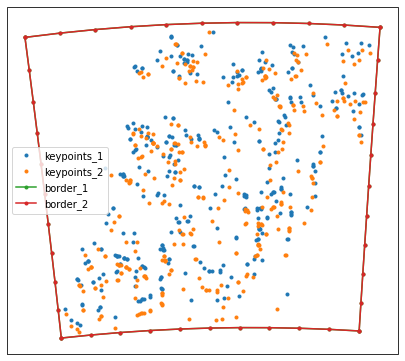

In [9]:
# Plot identified and matched keypoints in geographic coordinates for SAR1 and SAR2 

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

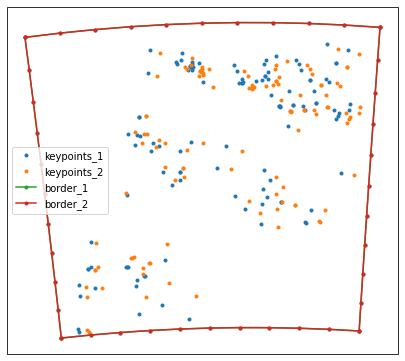

In [10]:
# Plot identified and matched keypoints in geographic coordinates for SAR2 and SARprediction

# convert row/column coordinates of matched features to lon/lat
lon1ft_er, lat1ft_er = n2.transform_points(c1_er, r1_er)
lon2ft_er, lat2ft_er = n3.transform_points(c2_er, r2_er)

# get lon/lat coordinates of the border of images
lon1b_er, lat1b_er = n2.get_border()
lon2b_er, lat2b_er = n3.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft_er, lat1ft_er, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft_er, lat2ft_er, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b_er, lat1b_er, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b_er, lat2b_er, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

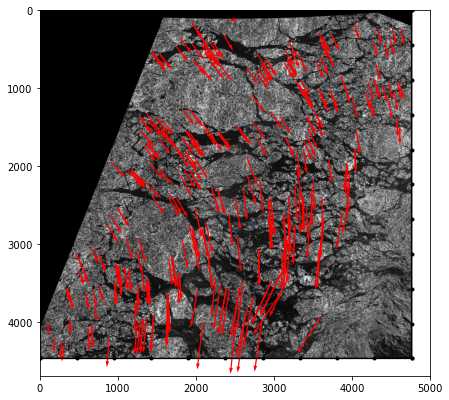

In [11]:
# Plot ice drift on top of image_1 for SAR1 and SAR2 

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

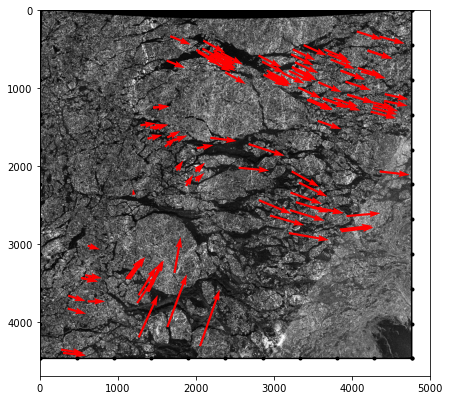

In [12]:
# Plot ice drift on top of image_1 for SAR2 and SAR2_prediction 

# end points in image_1 coordinate system
n1c2_er, n1r2_er = n2.transform_points(lon2ft_er, lat2ft_er, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr_er = n1r2_er - r1_er
dc_er = n1c2_er - c1_er

# border of image_2 in image_1 coordinate system
n1lon2b_er, n1lat2b_er = n2.transform_points(lon2b_er, lat2b_er, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n2[1], cmap='gray')
plt.quiver(c1_er, r1_er, dc_er, dr_er, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b_er, n1lat2b_er, 'k.-')
plt.show()

Ask Anton how to create this domain based on the projection from gdal object or just previous domain d but use worse resolution 2,5 km? Figure out the difference betweeen domains

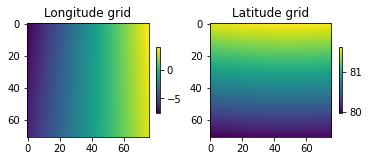

In [13]:
# Create lon/lat grids in Polar stereographic coordinate system 
# Extent of the grid roughly corresponds to the extent of the image_1

# projection (https://epsg.io/3413) or 3996
srs = NSR(3996)

# projected coordinates of the first image corners
rows, cols = n1.shape()
n1x, n1y = n1.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs)

# domain of interest with resolution 5000 (or 2500) m
dom_pm = Domain(srs, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 2500 2500')


# lon/lat grids in polar stereographic projection covering image_1
lon1pm, lat1pm = dom_pm.get_geolocation_grids()
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

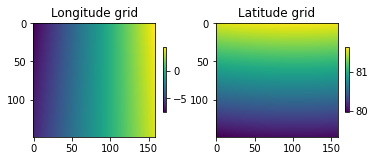

In [180]:
# Create lon/lat grids 

# lon/lat grids in polar stereographic projection covering image_1
pm_step = 30 # lon/lat grids are subsampled
lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

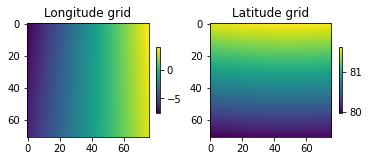

In [14]:
# Create lon/lat grids in Polar stereographic coordinate system  for SAR2 and SAR2_prediction 
# Extent of the grid roughly corresponds to the extent of the image_1

# projection (https://epsg.io/3413) or 3996
srs = NSR(3996)

# projected coordinates of the first image corners
rows, cols = n2.shape()
n2x, n2y = n2.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs)

# domain of interest with resolution 5000 (or 2500) m
dom_pm_er = Domain(srs, f'-te {n2x.min()} {n2y.min()} {n2x.max()} {n2y.max()} -tr 2500 2500')


# lon/lat grids in polar stereographic projection covering image_1
lon1pm_er, lat1pm_er = dom_pm_er.get_geolocation_grids()
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

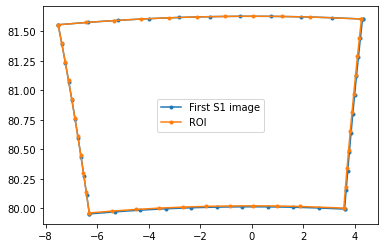

In [232]:
# plot coverage of the first S1 image and ROI
plt.plot(*n1.get_border(), '.-', label='First S1 image')
plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [15]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4())

100% 01000.0 04188.0 00979.0 04379.0 -03.0 0.72 13.10
 Pattern matching - OK! (  5 sec)


In [16]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix for SAR2 and SAR2_prediction 
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm_er, vpm_er, apm_er, rpm_er, hpm_er, lon2pm_er, lat2pm_er = pattern_matching(lon1pm_er, lat1pm_er, n2, c1_er, r1_er, n3, c2_er, r2_er,
                                                          srs=srs.ExportToProj4())

20% 04063.0 00875.0 04224.0 00922.0 +03.0 0.76 6.23

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


00% 00062.0 00063.0 00061.0 00095.0 -03.0 0.00 0nan3

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


94% 03563.0 04125.0 03784.0 04024.0 +00.0 0.39 5.202
 Pattern matching - OK! (  6 sec)


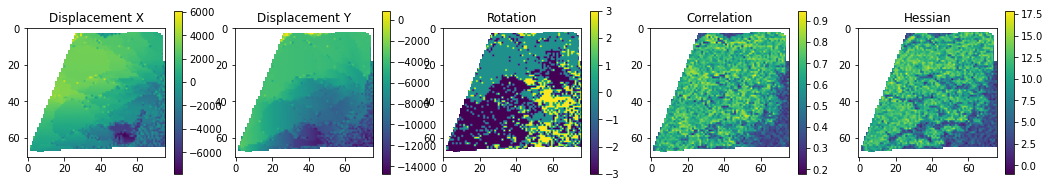

In [17]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

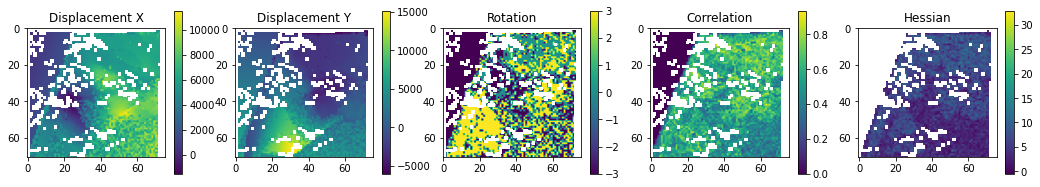

In [18]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm_er, vpm_er, apm_er, rpm_er, hpm_er]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

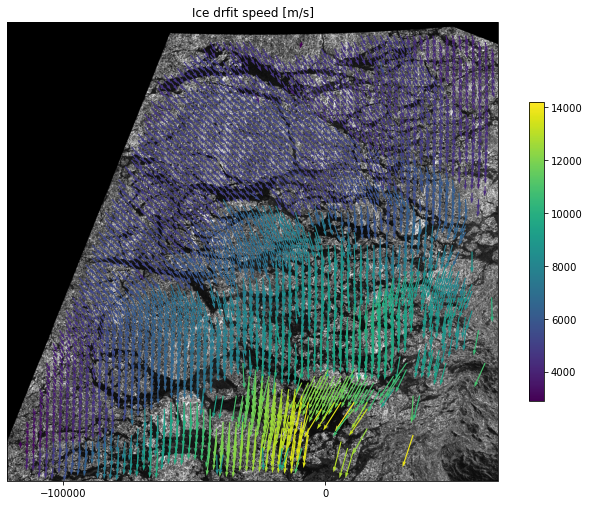

In [20]:
# compute ice drift speed [m/s]
delta_t = 1 #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.Mercator()

plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi],speed[gpi], scale=200000) #cmap='jet', width=0.008
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice displacement [m]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])


ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

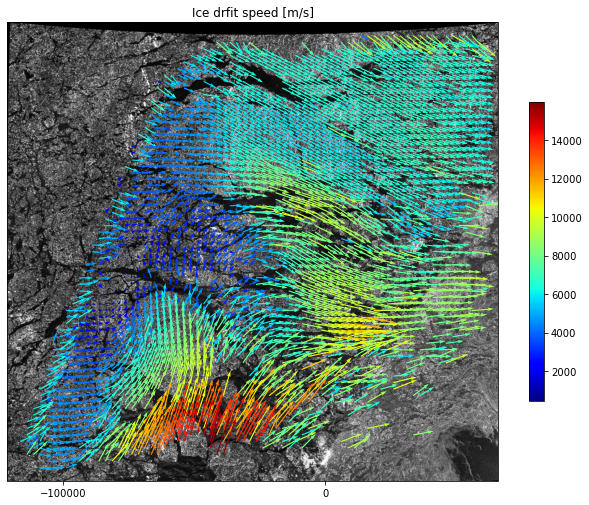

In [28]:
# compute ice drift speed [m/s]
delta_t = 1 #in seconds
u_er = upm_er / delta_t
v_er = vpm_er / delta_t
speed_er = np.sqrt((v_er**2+u_er**2)) 

# plot valid vectors in Polar stereographic projection
gpi_er = (hpm_er > 0) 
# X/Y grids in polar stereographic projection covering image_1
x1pm_er, y1pm_er = dom_pm_er.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.Mercator()

plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
quiv=ax.quiver(x1pm_er[gpi], y1pm_er[gpi], u_er[gpi], v_er[gpi],speed_er[gpi], scale=200000, cmap='jet') #cmap='jet', width=0.008
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice displacement[m]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])


ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

In [74]:
'''
delta_u = (u-u_er)
delta_v = (v-v_er)
# compute ice drift speed [m/s]
delta_t = 1 #in seconds
u_er = delta_u / delta_t
v_er = delta_v / delta_t
#speed2 = np.sqrt(delta_v**2+delta_u**2
delta_speed = speed_er*100/speed

# set the size and color of each point based on the difference value
sizes = np.abs(delta_speed)*0.5  # multiply by 10 to make the points larger

# X/Y grids in polar stereographic projection covering image_1
x1pm_er, y1pm_er = dom_pm_er.get_geolocation_grids(dst_srs=srs)

# spacial reference for plotting
crs = ccrs.Mercator()

plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)

ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
# plot the difference as a scatter plot on the map
scatter_plot = ax.scatter(x1pm_er, y1pm_er, s=sizes, c=delta_speed, cmap='jet')

# Add a legend
plt.colorbar(scatter_plot)
# display the plot
plt.show()


'''

"\ndelta_u = (u-u_er)\ndelta_v = (v-v_er)\n# compute ice drift speed [m/s]\ndelta_t = 1 #in seconds\nu_er = delta_u / delta_t\nv_er = delta_v / delta_t\n#speed2 = np.sqrt(delta_v**2+delta_u**2\ndelta_speed = speed_er*100/speed\n\n# set the size and color of each point based on the difference value\nsizes = np.abs(delta_speed)*0.5  # multiply by 10 to make the points larger\n\n# X/Y grids in polar stereographic projection covering image_1\nx1pm_er, y1pm_er = dom_pm_er.get_geolocation_grids(dst_srs=srs)\n\n# spacial reference for plotting\ncrs = ccrs.Mercator()\n\nplt.figure(figsize=(11,11))\nax = plt.axes(projection=crs)\n\nax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')\n# plot the difference as a scatter plot on the map\nscatter_plot = ax.scatter(x1pm_er, y1pm_er, s=sizes, c=delta_speed, cmap='jet')\n\n# Add a legend\nplt.colorbar(scatter_plot)\n# display the plot\nplt.show()\n\n\n"

In [99]:
#EXPORTING DRIFT POINTS WITH ALL DATA IN WGS COORDINATE SYSTEM in degrees (v and u - displacement)

#Replace inf with nan. It seems that lat2, lon2 sometimes get inf and it effects u and v
#then it gives errors in alignment algortihm
infu = np.where(np.isinf(upm))
infv = np.where(np.isinf(vpm))
upm[infu] = np.nan
vpm[infv] = np.nan


lon1_flat, lat1_flat = lon1pm.flatten(),lat1pm.flatten()

u_flat, v_flat, a_flat, r_flat, h_flat = upm.flatten(), vpm.flatten(), apm.flatten(), rpm.flatten(), hpm.flatten()

In [103]:
points=zip(lon1_flat,lat1_flat, u_flat, v_flat, a_flat, r_flat, h_flat)
#points=zip(lon1_flat,lat1_flat, u_flat, v_flat)
header=['lon1','lat1','u','v', 'a','r', 'h']

with open('/home/jovyan/work/Icedrift/Special_curriculum/19-20_subset_experiment/algorithm_drift/S2-S2_prediction_drift2.csv','w') as f: 
    out = csv.writer(f, delimiter=',')
    out.writerow(header) 
    out.writerows(points)

In [58]:
#EXPORTING DATA TO 'DEFORMATION' NOTEBOOK, GETTING BACK RESULTS AND VISUALIZING DEFORMATION
%store upm
%store vpm
%store rpm
%store hpm
%store f1
%store f2
%store delta_t

Stored 'upm' (ndarray)
Stored 'vpm' (ndarray)
Stored 'rpm' (ndarray)
Stored 'hpm' (ndarray)
Stored 'f1' (NoneType)
Stored 'f2' (NoneType)
Stored 'delta_t' (int)


In [59]:
%store -r divergence_sr
%store -r convergence_sr
%store -r shear_sr
%store -r total_sr

%store -r divergence_dr
%store -r convergence_dr
%store -r shear_dr
%store -r total_dr

%store -r e_div_dr

%store -r divergence_n2
%store -r convergence_n2
%store -r shear_n2
%store -r total_n2

%store -r e_tot

In [62]:
mskt = (total_dr>5)
# filter mask
msk_total_dr  = mskt*1

# filter data arrays    
total_dr_msk = total_dr*mskt

# set no data to nan
total_dr_msk[mskt==0.0] = np.nan

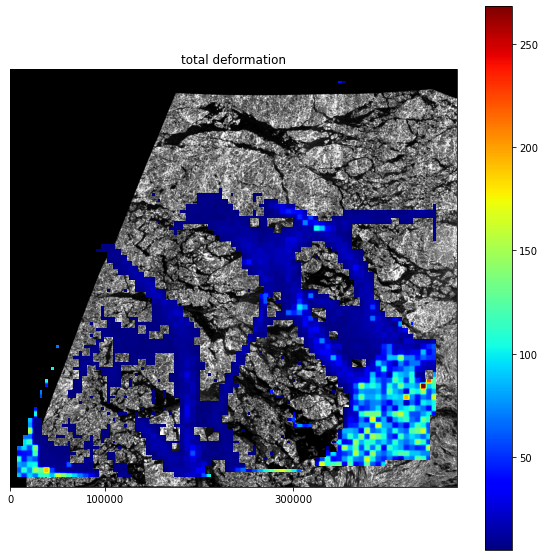

In [63]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

#(axes)  = plt.subplots(2,2, figsize=(30,30), sharex='all', sharey='all')
ax.imshow(a2, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
im=ax.imshow(total_dr_msk, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', cmap = 'jet') # for transparency  alpha = 0.3
plt.title('total deformation')
#divider = make_axes_locatable(axes[0][0])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#clb1 = plt.colorbar(pm1, cax=cax)
#clb1.ax.set_xlabel(clb_txt)
#clb1.ax.tick_params(labelsize=FS-5)

ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
#plt.axes('off')
plt.colorbar(im)

    
    
plt.show()

